In [ ]:
# !pip yfinance -q

ERROR: unknown command "yfinance"


In [1]:
import yfinance as yf
import random 
import numpy as np
import pandas as pd
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
import gc
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline


### **Stock Indicators**

In [685]:
def technical_indicators(df):
  df['Volume']=df['Volume']/1000000
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
    #SMA  #10days
  df['SMA10'] = df11['Close'].rolling(10).mean()
    #EMA
  df11['EWMA30'] = df11['Close'].ewm(span=10).mean()

  # df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     
  df11['rs'] = df11.avg_gain / df11.avg_loss
  df11['rsi'] = 100 - (100 / (1 + df11.rs))

   #stochastic oscillator
  df['14-high'] = df['High'].rolling(14).max()
  df['14-low'] = df['Low'].rolling(14).min()
  df['%K'] = (df['Close'] - df['14-low'])*100/(df['14-high'] - df['14-low'])
  df['%D'] = df['%K'].rolling(3).mean() 

  #MACD
  k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
  d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
  macd = k - d
  macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
  macd_h = macd - macd_s

  df['macd'] = df.index.map(macd)
  df['macd_h'] = df.index.map(macd_h)
  df['macd_s'] = df.index.map(macd_s)
    #A/D
  df['cmfv'] = ((df['Close']-df['Low'])-(df['High']-df['Close']))/df['High']-df['Low']*df['Volume']
  df['A/D'] = df['cmfv'].cumsum()

    #OBV
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  #ROC
  N=df['Close'].diff(13)
  D=df['Close'].shift(13)
  df['ROC'] = pd.Series(100*N/D)

  #william R
  highh = df['High'].rolling(14).max() 
  lowl = df['Low'].rolling(14).min()
  df['wr'] = -100 * ((highh - df['Close']) / (highh - lowl))

  #disparity index
  ma = df['Close'].rolling(14).mean()
  df['disparity'] = ((df['Close'] - ma) / ma) * 1000


  df11.drop(columns=['Close','change','index','gain','loss','avg_gain','avg_loss','rs'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat

dir=["AAPL"]
dfs=[]
for i in range(len(dir)):
  Stock = pd.read_csv(dir[i]+".csv")
  USED_LENGTH=int(0.5*len(Stock))
  Stock = (Stock.iloc[USED_LENGTH:]).reset_index()    #only use generate prediction
  df=technical_indicators(Stock).drop(columns=['Date','Adj Close','index'])
  dfs.append(df)


print("Used length", USED_LENGTH)
assert(len(dfs)==len(dir))

FEATURE=dfs[0].shape[-1]
print(FEATURE)
print(dfs[0].columns)
dfs[0]


Used length 1676
22
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'SMA10', '14-high',
       '14-low', '%K', '%D', 'macd', 'macd_h', 'macd_s', 'cmfv', 'A/D', 'obv',
       'ROC', 'wr', 'disparity', 'EWMA30', 'rsi'],
      dtype='object')


,Open,High,Low,Close,Volume,change,SMA10,14-high,14-low,%K,...,macd_h,macd_s,cmfv,A/D,obv,ROC,wr,disparity,EWMA30,rsi
0,26.450001,26.625000,26.375000,26.500000,99.4556,0.025000,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2623.141450,-2.623141e+03,0.0000,7.150943,-19.047619,45.787575,26.500000,67.134431
1,26.415001,26.642500,26.410000,26.525000,118.6496,0.025000,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-3133.536030,-5.756677e+03,118.6496,7.150943,-19.047619,45.787575,26.513750,67.134431
2,26.535000,26.700001,26.405001,26.682501,106.8060,0.157501,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2820.202799,-8.576880e+03,225.4556,7.150943,-19.047619,45.787575,26.581587,67.134431
3,26.924999,27.000000,26.705000,26.932501,107.2100,0.250000,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2863.037124,-1.143992e+04,332.6656,7.150943,-19.047619,45.787575,26.697197,67.134431
4,26.975000,27.075001,26.877501,26.924999,107.5216,-0.007502,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2889.915697,-1.432983e+04,225.1440,7.150943,-19.047619,45.787575,26.762593,67.134431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,165.000000,165.600006,163.889999,165.330002,41.9496,0.309998,164.800002,168.160004,159.779999,66.229113,...,-0.260908,3.000341,-6875.112837,-1.527152e+07,6815.6364,-0.181128,-33.770887,4.574498,165.053623,59.225082
1673,165.190002,166.309998,163.729996,163.770004,48.7141,-1.559998,165.097002,168.160004,159.779999,47.613396,...,-0.432403,2.892241,-7975.974430,-1.527950e+07,6766.9223,0.006112,-52.386604,-4.100374,164.820238,54.771877
1674,163.059998,165.279999,162.800003,163.759995,45.4988,-0.010009,165.463001,168.160004,159.779999,47.493957,...,-0.544232,2.756183,-7407.208165,-1.528691e+07,6721.4235,-0.546586,-52.506043,-4.161239,164.627466,54.743436
1675,165.190002,168.559998,165.190002,168.410004,64.9023,4.650009,165.748001,168.559998,159.779999,98.291640,...,-0.314170,2.677640,-10721.192854,-1.529763e+07,6786.3258,3.937546,-1.708360,22.450438,165.315200,64.076414


In [686]:
#Normalize time series
# Scalers = [ StandardScaler() for _ in range(len(dfs)) ]
dfs_standard=[]
for i in range(len(dfs)):
  dataset_standard = dfs[i]#Scalers[i].fit_transform(dfs[i])
  dfs_standard.append(dataset_standard)

print(dfs_standard[0].shape)

(1677, 22)


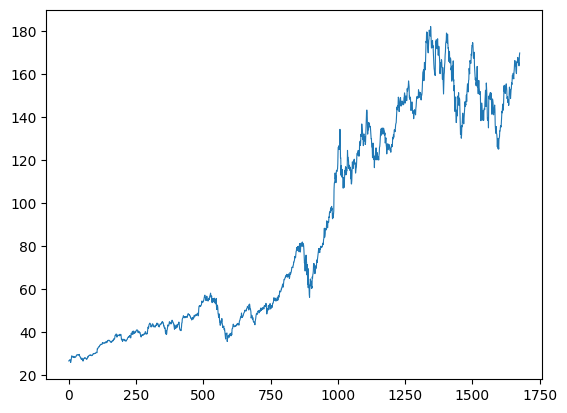

In [687]:
stock_price_array=np.array(dfs_standard[0])[:,3]   #Price   3
plt.plot(stock_price_array, linewidth=0.8)

# plt.annotate("AAPL",xy=(0,30),textcoords='offset points', fontsize=20)

In [688]:
stock_price_array=np.array(dfs_standard[0])[:,3]
stock_array=np.array(dfs_standard[0])
print(stock_array.shape)

(1677, 22)


### **Train Test Split**

1006
X_train length 1006
X_test length 671


<ipython-input-689-c1aa4a35eb3e>:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("AAPL",xy=(0,20),textcoords='offset points', fontsize=20)


Text(0, 20, 'AAPL')

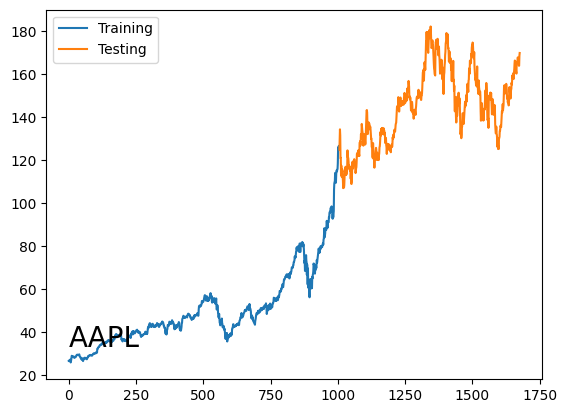

In [689]:
used_length=int(len(stock_array)*0.6)

stock_price_train=stock_price_array[:used_length]
stock_train=stock_array.copy()[:used_length]

stock_price_test=stock_price_array[used_length:]
stock_test=stock_array[used_length:]

print(used_length)

print("X_train length", len(stock_train))
print("X_test length", len(stock_test))

plt.plot(stock_price_train,label='Training')
plt.plot(np.arange(len(stock_price_train),len(stock_array)),stock_price_test, label='Testing')
plt.legend()
plt.annotate("AAPL",xy=(0,20),textcoords='offset points', fontsize=20)

### **Use Transformer Generated Prediction**

In [690]:
stock_train.shape

(1006, 22)

In [691]:
transformer_pred = np.array(pd.read_csv("AAPL_Pred.csv"))[USED_LENGTH:, 1:]
print(transformer_pred.shape)
transformer_pred_train=transformer_pred[:used_length]
transformer_pred_test=transformer_pred[used_length:]

print("pred train len",transformer_pred_train.shape)
print("pred test len",transformer_pred_test.shape)

(1677, 7)
pred train len (1006, 7)
pred test len (671, 7)


### **Visualize Actual & Prediction**

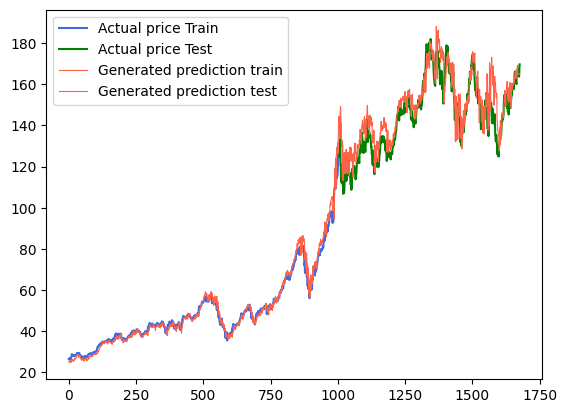

In [692]:
plt.plot(stock_price_train,label='Actual price Train', color='royalblue')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),stock_price_test,label='Actual price Test', color='green')
plt.plot(transformer_pred_train[:,0], label='Generated prediction train',linewidth=0.8, color='tomato')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),transformer_pred_test[:,0], label='Generated prediction test',linewidth=0.8, color='tomato')
plt.legend()

In [693]:
stock_price_train.max()

126.522499

In [694]:
transformer_pred[0]   #each day we have a window of prediction of next 7 days

array([25.217367, 25.249771, 25.186594, 25.253185, 25.226475, 25.187412,
       25.199465])

### **Create Trading Game**

In [695]:
TRANSACTION=0.0001
CONTEXT=30
LOOK_FORWARD=7
class Game:  # Create tradin game step day by day through the stock, look at a window of prices, and try to make actions at each timestep
    def __init__(self, w=CONTEXT, stock=stock_train, stock_price=stock_price_train, transformer_pred=transformer_pred_train):
        self.w = w #window size
        self.stock=stock
        self.stock_price=stock_price
        self.transformer_pred=transformer_pred
        self.reset() 

    def reset(self):
        # restart game, initialize game state
        self.money=1000000 
        self.positions=10000   # shares holding

        self.today=CONTEXT-LOOK_FORWARD-1      #30- 7-1   =22           0~22,      22 ,     23~29
        self.inital_property=self.positions*self.stock_price[self.today]+self.money  #initial total investment = 10,000 shares + cash

        
        self.window_right=self.w-1   #29
        self.window_left=0         
        
        self.today_price = self.stock_price[self.today]        
        self.window = self.stock_price[ self.window_left:self.today+1] #price    0~14

        self.window_all=self.stock[ self.window_left:self.today+1]  #22 features
        
        self.previous_reward=0  #to store and plot the mean reward during each game to see if improves
        self.yesterday_property= self.inital_property
        self.profit=0 
        
        
        self.money_record=[self.money]*CONTEXT
        self.positions_record=[self.positions]*CONTEXT

        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]

        self.window_pred=self.transformer_pred[self.today]   # transformer predictions

        
    def play_step(self, action):
        self.yesterday_price=self.money
        self.yesterday_property=(self.money + self.today_price*self.positions )

        # 2. make a move, compute money, update positions
        self.money=self.money - self.today_price * action
         #update positions
        self.positions += action     #shares in hand

        self.money_record.append(self.money)
        self.positions_record.append(self.positions)

        self.today += 1  # update the head and window
        self.today_price=self.stock_price[self.today] 
        #move window forward
        self.window_left += 1 
        self.window_right += 1 

        self.window=self.stock_price[self.window_left:self.today+1]       #past prices

        self.window_all=self.stock[self.window_left:self.today+1]         #past indicators

        self.window_pred=self.transformer_pred[self.today+1]   # transformer predictions


        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]


        # 3. check if game over
        game_over = False

        if self.is_collision():
            
            game_over = True
            reward = (self.money + self.today_price*self.positions ) - self.yesterday_property      -  abs(action)*TRANSACTION
            # reward/=10
            reward = reward+ 100*(self.window_pred.mean() - self.window_pred[0]) * action
            #calculate profit at the end of each game
            self.profit= ((self.money + self.today_price*self.positions )-self.inital_property) /self.inital_property  #profitability at the end of each game
            
            return reward, game_over

        #the reward function will be defined as the difference between the portfolio value 
        #at the end of the time step and the portfolio value at the beginning of the time step.

        reward= (self.money + self.today_price*self.positions ) - self.yesterday_property            -  abs(action)*TRANSACTION
        # reward/=10
        
        # print("curriculum",0.1*(self.right_mean-self.left_mean)*action 
        reward= reward+ 100*(self.window_pred.mean()- self.window_pred[0]) * action 
                #curriculum1: if right mean > left mean, and you buy today, then reward the agent, vice versa for sell
                
        return reward, game_over


    def is_collision(self):
        # hits boundary 
        if self.window_right>len(self.stock_price)-2:
            return 1
        return 0


In [696]:
stock_train.shape

(1006, 22)

### **Define State, Action Space**

In [697]:
STATE_SIZE=2+ stock_train.shape[-1] #prices in window + position and money in hand
print("State size:", STATE_SIZE)  # state size is of length CONTEXT  * customized dimensions 
ACTION_SPACE=np.arange(-2000,2001,200).tolist()    #actions
ACTION_SIZE=len(ACTION_SPACE)
print("Action_size:", ACTION_SIZE)
print("Action_space:", ACTION_SPACE)

State size: 24
Action_size: 21
Action_space: [-2000, -1800, -1600, -1400, -1200, -1000, -800, -600, -400, -200, 0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]


### **Build Double Q leaning**

In [698]:
MAX_MEMORY = 10000 # record 40000 state, action, reward, next_state, done tuples
BATCH_SIZE = 512
criterion = nn.SmoothL1Loss()
LR = 0.001
GAMMA=0.999
TAU=0.5
Q_UPDATE_FREQ=20
#Qnet for a given state action pair gives value
class QNetwork(nn.Module):
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256):
        super(QNetwork, self).__init__()
        self.embedding=nn.Sequential(
        nn.Conv1d(state_size, hidden_size, kernel_size=5, stride=1, padding=2, bias=False ),
        nn.GELU(),
        nn.BatchNorm1d(hidden_size),

        nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        nn.BatchNorm1d(hidden_size),
        )

        self.fc=nn.Sequential(
            
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU()
        )
        self.Linear_out=nn.Linear(hidden_size * CONTEXT, action_size)
    def forward(self, x):

        out=self.embedding(torch.transpose(x,1,2))
        out=self.fc(torch.transpose(out,1,2))

        out=self.Linear_out(    out.flatten(1)   )
        return out

class DoubleDQN:
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256, lr=LR, tau=TAU,
                 q_update_freq=Q_UPDATE_FREQ, 
                 ):
        self.q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.tau = tau
        self.total_steps=0
        self.q_update_freq=q_update_freq

    def soft_update(self):
        if self.total_steps % self.q_update_freq==0:
          for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
              target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)

    def train_step(self, state, action, reward, next_state, done):
      self.total_steps += 1

      states_tensor = torch.FloatTensor(state)  #b * state_size 
      actions_tensor = torch.LongTensor(action)  #b 
      rewards_tensor = torch.FloatTensor(reward) #b 
      next_states_tensor = torch.FloatTensor(next_state)  #b * state_size 
      dones_tensor = torch.BoolTensor(done)  #b

      with torch.no_grad():
        q_next=self.target_q_net(next_states_tensor) #use 2-Qnet to estimate target Q
        max_q_next,_ = torch.max(q_next, dim=1)
        q_target = rewards_tensor + GAMMA * max_q_next * (~dones_tensor)

      q_pred = self.q_net(states_tensor)    #use 1-Qnet to get current Q rped
      actions_index=[]
      for b in range(BATCH_SIZE):
        #print(actions_tensor[b])
        actions_index.append(ACTION_SPACE.index(actions_tensor[b]))
      actions_index=torch.tensor(actions_index, dtype=torch.int64)

      q_values_pred_selected = q_pred.gather(1, actions_index.unsqueeze(1)).squeeze(1)

      loss = criterion(q_values_pred_selected, q_target) /(BATCH_SIZE)           

      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1e+8)
      self.optimizer.step()

      self.soft_update()

      return loss.item()

### **Create Agent that play the game and sample experiences to train**

In [699]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.trainer = DoubleDQN() 
        self.memory = deque(maxlen=MAX_MEMORY) # a collection of past experiences 

    def get_state(self, game):

        window_all=np.array(game.window_all )
        money_window=(np.array(game.money_window)/10000).reshape(-1,1)   #your money
        positions_window=(np.array(game.positions_window)/100).reshape(-1,1)
        
        pred_window = np.array(game.window_pred ).reshape(-1,1)

        assert(game.money>=0.0)
        assert(game.positions>=0.0)

        state= np.concatenate( [positions_window, money_window, window_all], axis=-1  ) # 24, 24

        pred_window_repeat=np.repeat(pred_window, state.shape[-1], axis=-1)   #9, 24

        state=np.concatenate([state, pred_window_repeat], axis=0)   #30, 24

        return state

    def remember(self, state, action, reward, next_state, done):
        # state=(state- np.mean(state,axis=0))/np.std(state,axis=0) #normalize
        reward/=100
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached


    def train_batch_experience(self):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
        return 0.
            
    def get_action(self, state, game):    # e p s i l o n greedy---------------------------------------------------------------------------------
        #80% possibility of taking random action. decrease in time
        self.epsilon = 100 - self.n_games//2   #2 games reduce 1% chance of choosing action other than the best action
        if self.epsilon<5:
          self.epsilon=5 #not allowing below 5%  randomness
        position=game.positions
        money=game.money

        today_price=game.today_price

        final_move=0.
        #explore random actions
        if random.randint(0, 100) < max(self.epsilon,0) or (len(self.memory) <= BATCH_SIZE):
            actions=np.array(ACTION_SPACE)
            final_move=np.random.choice(actions)  
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price >= money:
              for a in reversed(ACTION_SPACE): # find action that doesn't use up all your money in action space
                if a>=0 and a*today_price < money:
                  return a
              
            if final_move<0 and final_move<-position:    
              for a in ACTION_SPACE:  #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        #take max q action
        else:
            state_input = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            # print("QpredstateL",state_input.shape)
            Q_pred= self.trainer.q_net(state_input)
            move = torch.argmax(Q_pred).item() # 
            #allowable=np.clip(move, -position, money//today_price)    
            final_move=ACTION_SPACE[move]
            
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price > money:
              for a in reversed(ACTION_SPACE):
                if a>=0 and a*today_price< money: #find action that doesn't use up all your money in action space
                  # print("action", a, today_price, money)
                  return a
            
            if final_move<0 and final_move<-position:   
              for a in ACTION_SPACE: #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        if final_move>0 and final_move*today_price >= money:
          # print("action", a, today_price, money)
          return 0.
        if final_move<0 and final_move<-position:
          return 0.

        return final_move

actions=[]
plot_profit=[]
plot_reward=[]
plot_loss=[]
agent = Agent()
def train():
    rewards = []
    record = 0
    game = Game(w=CONTEXT, stock=stock_train, stock_price=stock_price_train, transformer_pred=transformer_pred_train)
    epoch=200000 #a very large number just to keep the game running
    optimizer=agent.trainer.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stock_price_train.shape[0]*3, gamma=0.995)
    for i in tqdm( range(1,epoch+1) ):
        
        curr_lr = float(optimizer.param_groups[0]['lr'])
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)
        # memory stored for replay
        agent.remember(state_old, action, reward, state_new, done)
        #loss=agent.train_single_experience(state_old, action, reward, state_new, done)

          
        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward.append(mean_reward)
            rewards=[]
            # train minibatch
            loss=agent.train_batch_experience()
            plot_loss.append(loss)
            game.reset()
            agent.n_games += 1
            
            if profit > record:
                record = profit
               # agent.model.save()


            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon,"lr",round(curr_lr,6), "loss", round(loss,6))

            plot_profit.append(profit)
        scheduler.step()


In [700]:
# from google.colab import drive
# drive.mount('/content/drive')

In [701]:
# PATH = "/content/drive/MyDrive/checkpoint01"
# torch.save(agent.trainer.q_net.state_dict(), PATH)

In [702]:
gc.collect()
torch.cuda.empty_cache()

### **Train and see Rewards and Profits**

In [703]:
train()
#profit is the percentage of cumulated money through the money over money that I had in hand before the game
#mean reward is the average daily dollar returns in each game

  0%|          | 0/200000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  1%|          | 1950/200000 [00:02<03:46, 875.11it/s]

Game 1 mean Reward 1844.89 Profit 146.89 Record: 146.89 eps 100 lr 0.001 loss 0.910344


  1%|▏         | 2834/200000 [00:03<04:32, 724.36it/s]

Game 2 mean Reward 1397.23 Profit 121.93 Record: 146.89 eps 100 lr 0.001 loss 0.987442


  2%|▏         | 3702/200000 [00:05<04:59, 655.63it/s]

Game 3 mean Reward -3103.06 Profit 101.03 Record: 146.89 eps 99 lr 0.001 loss 0.853804


  2%|▏         | 4462/200000 [00:07<05:21, 608.80it/s]

Game 4 mean Reward -3743.22 Profit 131.56 Record: 146.89 eps 99 lr 0.000995 loss 0.906227


  3%|▎         | 5558/200000 [00:09<05:04, 638.20it/s]

Game 5 mean Reward -4124.86 Profit 152.25 Record: 152.25 eps 98 lr 0.000995 loss 0.803868


  3%|▎         | 6059/200000 [00:10<07:21, 438.90it/s]

Game 6 mean Reward 5904.23 Profit 111.85 Record: 152.25 eps 98 lr 0.000995 loss 0.760555


  4%|▎         | 7257/200000 [00:13<07:34, 424.24it/s]

Game 7 mean Reward -1357.19 Profit 146.24 Record: 152.25 eps 97 lr 0.00099 loss 0.71188


  4%|▍         | 8269/200000 [00:15<05:52, 544.03it/s]

Game 8 mean Reward 4010.83 Profit 133.71 Record: 152.25 eps 97 lr 0.00099 loss 0.840959


  5%|▍         | 9300/200000 [00:17<05:30, 576.93it/s]

Game 9 mean Reward 801.32 Profit 190.19 Record: 190.19 eps 96 lr 0.00099 loss 0.857803


  5%|▌         | 10205/200000 [00:18<05:38, 560.52it/s]

Game 10 mean Reward 431.71 Profit 43.64 Record: 190.19 eps 96 lr 0.000985 loss 0.734228


  6%|▌         | 11122/200000 [00:20<05:41, 553.10it/s]

Game 11 mean Reward -655.93 Profit 188.1 Record: 190.19 eps 95 lr 0.000985 loss 0.78945


  6%|▌         | 12122/200000 [00:22<05:24, 579.83it/s]

Game 12 mean Reward 1075.82 Profit 48.18 Record: 190.19 eps 95 lr 0.000985 loss 0.840159


  6%|▋         | 12895/200000 [00:24<07:23, 422.04it/s]

Game 13 mean Reward 313.66 Profit 83.86 Record: 190.19 eps 94 lr 0.00098 loss 0.843262


  7%|▋         | 14098/200000 [00:27<07:19, 423.31it/s]

Game 14 mean Reward 2361.65 Profit 155.86 Record: 190.19 eps 94 lr 0.00098 loss 0.771481


  7%|▋         | 14972/200000 [00:28<06:16, 490.83it/s]

Game 15 mean Reward 4687.92 Profit 88.32 Record: 190.19 eps 93 lr 0.00098 loss 0.907316


  8%|▊         | 15800/200000 [00:30<06:32, 469.02it/s]

Game 16 mean Reward 1701.32 Profit 141.33 Record: 190.19 eps 93 lr 0.000975 loss 0.828572


  9%|▊         | 17065/200000 [00:32<06:16, 486.00it/s]

Game 17 mean Reward 959.86 Profit 186.74 Record: 190.19 eps 92 lr 0.000975 loss 0.900191


  9%|▉         | 17798/200000 [00:34<07:05, 428.29it/s]

Game 18 mean Reward -1443.77 Profit 189.79 Record: 190.19 eps 92 lr 0.000975 loss 0.742138


  9%|▉         | 18797/200000 [00:36<06:12, 487.10it/s]

Game 19 mean Reward -3289.64 Profit 148.49 Record: 190.19 eps 91 lr 0.00097 loss 0.850668


 10%|▉         | 19801/200000 [00:39<09:27, 317.26it/s]

Game 20 mean Reward 3243.4 Profit 93.78 Record: 190.19 eps 91 lr 0.00097 loss 0.775673


 10%|█         | 20969/200000 [00:41<06:05, 489.94it/s]

Game 21 mean Reward 5127.08 Profit 91.41 Record: 190.19 eps 90 lr 0.00097 loss 0.845081


 11%|█         | 21701/200000 [00:42<06:46, 438.41it/s]

Game 22 mean Reward 2244.57 Profit 233.29 Record: 233.29 eps 90 lr 0.000966 loss 0.875069


 11%|█▏        | 22850/200000 [00:45<06:40, 442.18it/s]

Game 23 mean Reward 7465.46 Profit 253.08 Record: 253.08 eps 89 lr 0.000966 loss 0.795367


 12%|█▏        | 23692/200000 [00:46<07:06, 413.48it/s]

Game 24 mean Reward 3860.3 Profit 239.85 Record: 253.08 eps 89 lr 0.000966 loss 0.871379


 12%|█▏        | 24804/200000 [00:48<06:09, 473.57it/s]

Game 25 mean Reward -43.25 Profit 266.3 Record: 266.3 eps 88 lr 0.000961 loss 0.944058


 13%|█▎        | 25670/200000 [00:51<09:43, 298.54it/s]

Game 26 mean Reward 3239.41 Profit 237.82 Record: 266.3 eps 88 lr 0.000961 loss 0.835195


 13%|█▎        | 26771/200000 [00:53<06:40, 432.80it/s]

Game 27 mean Reward 2035.17 Profit 238.14 Record: 266.3 eps 87 lr 0.000961 loss 0.789662


 14%|█▍        | 27671/200000 [00:55<06:31, 439.84it/s]

Game 28 mean Reward 5862.57 Profit 243.91 Record: 266.3 eps 87 lr 0.000956 loss 0.921714


 14%|█▍        | 28683/200000 [00:57<06:32, 436.18it/s]

Game 29 mean Reward 2356.91 Profit 266.41 Record: 266.41 eps 86 lr 0.000956 loss 0.818297


 15%|█▍        | 29487/200000 [00:59<06:46, 419.50it/s]

Game 30 mean Reward 2435.93 Profit 271.88 Record: 271.88 eps 86 lr 0.000956 loss 0.928548


 15%|█▌        | 30457/200000 [01:01<06:47, 416.17it/s]

Game 31 mean Reward 2369.55 Profit 210.46 Record: 271.88 eps 85 lr 0.000951 loss 0.842077


 16%|█▌        | 31380/200000 [01:03<09:36, 292.73it/s]

Game 32 mean Reward 3602.1 Profit 238.28 Record: 271.88 eps 85 lr 0.000951 loss 0.847852


 16%|█▋        | 32572/200000 [01:06<07:13, 386.44it/s]

Game 33 mean Reward -376.86 Profit 269.28 Record: 271.88 eps 84 lr 0.000951 loss 0.908629


 17%|█▋        | 33518/200000 [01:08<06:54, 401.42it/s]

Game 34 mean Reward 6878.99 Profit 275.18 Record: 275.18 eps 84 lr 0.000951 loss 0.876346


 17%|█▋        | 34519/200000 [01:10<06:13, 443.39it/s]

Game 35 mean Reward 2925.86 Profit 243.78 Record: 275.18 eps 83 lr 0.000946 loss 0.833862


 18%|█▊        | 35435/200000 [01:12<07:02, 389.35it/s]

Game 36 mean Reward 541.59 Profit 269.16 Record: 275.18 eps 83 lr 0.000946 loss 0.863533


 18%|█▊        | 36369/200000 [01:14<06:53, 395.29it/s]

Game 37 mean Reward 2402.39 Profit 275.98 Record: 275.98 eps 82 lr 0.000946 loss 0.904603


 19%|█▊        | 37256/200000 [01:16<09:49, 275.85it/s]

Game 38 mean Reward 1743.73 Profit 226.2 Record: 275.98 eps 82 lr 0.000942 loss 0.987911


 19%|█▉        | 38322/200000 [01:19<08:44, 308.12it/s]

Game 39 mean Reward 2856.35 Profit 290.77 Record: 290.77 eps 81 lr 0.000942 loss 0.981222


 20%|█▉        | 39240/200000 [01:20<07:13, 370.42it/s]

Game 40 mean Reward 5637.28 Profit 276.53 Record: 290.77 eps 81 lr 0.000942 loss 0.872004


 20%|██        | 40376/200000 [01:22<06:12, 428.71it/s]

Game 41 mean Reward 5461.18 Profit 266.84 Record: 290.77 eps 80 lr 0.000937 loss 0.981222


 21%|██        | 41252/200000 [01:24<06:47, 390.02it/s]

Game 42 mean Reward 3002.42 Profit 280.26 Record: 290.77 eps 80 lr 0.000937 loss 0.985959


 21%|██        | 42227/200000 [01:26<07:13, 363.86it/s]

Game 43 mean Reward 7963.54 Profit 283.08 Record: 290.77 eps 79 lr 0.000937 loss 1.06708


 22%|██▏       | 43054/200000 [01:29<12:15, 213.47it/s]

Game 44 mean Reward 1592.59 Profit 287.88 Record: 290.77 eps 79 lr 0.000932 loss 0.835561


 22%|██▏       | 44073/200000 [01:32<07:55, 328.13it/s]

Game 45 mean Reward 1915.86 Profit 306.01 Record: 306.01 eps 78 lr 0.000932 loss 0.923572


 23%|██▎       | 45063/200000 [01:34<06:50, 377.21it/s]

Game 46 mean Reward 5508.96 Profit 301.6 Record: 306.01 eps 78 lr 0.000932 loss 0.935305


 23%|██▎       | 46050/200000 [01:36<06:40, 384.32it/s]

Game 47 mean Reward 1010.27 Profit 277.74 Record: 306.01 eps 77 lr 0.000928 loss 0.933851


 24%|██▎       | 47055/200000 [01:38<06:36, 385.69it/s]

Game 48 mean Reward 5632.42 Profit 255.89 Record: 306.01 eps 77 lr 0.000928 loss 0.940689


 24%|██▍       | 47979/200000 [01:40<07:09, 354.15it/s]

Game 49 mean Reward 3729.04 Profit 256.81 Record: 306.01 eps 76 lr 0.000928 loss 0.938493


 24%|██▍       | 48986/200000 [01:43<11:28, 219.32it/s]

Game 50 mean Reward 1968.58 Profit 225.13 Record: 306.01 eps 76 lr 0.000923 loss 0.952783


 25%|██▍       | 49939/200000 [01:45<07:24, 337.72it/s]

Game 51 mean Reward 2943.49 Profit 161.91 Record: 306.01 eps 75 lr 0.000923 loss 0.905644


 25%|██▌       | 50997/200000 [01:47<07:45, 320.18it/s]

Game 52 mean Reward 6124.65 Profit 210.32 Record: 306.01 eps 75 lr 0.000923 loss 0.815124


 26%|██▌       | 51872/200000 [01:49<07:30, 328.66it/s]

Game 53 mean Reward 1082.42 Profit 268.19 Record: 306.01 eps 74 lr 0.000918 loss 0.914815


 26%|██▋       | 52898/200000 [01:51<07:13, 339.29it/s]

Game 54 mean Reward 7446.4 Profit 325.35 Record: 325.35 eps 74 lr 0.000918 loss 0.866791


 27%|██▋       | 53870/200000 [01:54<09:39, 252.11it/s]

Game 55 mean Reward 7012.47 Profit 306.67 Record: 325.35 eps 73 lr 0.000918 loss 0.859098


 27%|██▋       | 54889/200000 [01:57<09:15, 261.30it/s]

Game 56 mean Reward 6600.89 Profit 266.65 Record: 325.35 eps 73 lr 0.000914 loss 0.788716


 28%|██▊       | 55771/200000 [01:59<07:34, 317.17it/s]

Game 57 mean Reward 2365.46 Profit 291.58 Record: 325.35 eps 72 lr 0.000914 loss 0.838276


 28%|██▊       | 56762/200000 [02:01<07:41, 310.62it/s]

Game 58 mean Reward 3670.9 Profit 269.21 Record: 325.35 eps 72 lr 0.000914 loss 0.943196


 29%|██▉       | 57776/200000 [02:03<07:09, 331.33it/s]

Game 59 mean Reward 3922.83 Profit 297.14 Record: 325.35 eps 71 lr 0.000909 loss 1.026271


 29%|██▉       | 58831/200000 [02:05<07:00, 335.43it/s]

Game 60 mean Reward 2113.77 Profit 286.8 Record: 325.35 eps 71 lr 0.000909 loss 0.951126


 30%|██▉       | 59649/200000 [02:09<13:40, 171.06it/s]

Game 61 mean Reward 5468.37 Profit 280.31 Record: 325.35 eps 70 lr 0.000909 loss 0.958452


 30%|███       | 60651/200000 [02:11<07:44, 300.10it/s]

Game 62 mean Reward 3967.14 Profit 292.93 Record: 325.35 eps 70 lr 0.000905 loss 0.910163


 31%|███       | 61682/200000 [02:13<06:49, 337.41it/s]

Game 63 mean Reward 1520.65 Profit 301.22 Record: 325.35 eps 69 lr 0.000905 loss 0.884949


 31%|███▏      | 62620/200000 [02:15<07:27, 306.80it/s]

Game 64 mean Reward 1614.09 Profit 294.74 Record: 325.35 eps 69 lr 0.000905 loss 0.983153


 32%|███▏      | 63678/200000 [02:17<07:08, 318.40it/s]

Game 65 mean Reward 7366.64 Profit 314.88 Record: 325.35 eps 68 lr 0.0009 loss 0.824397


 32%|███▏      | 64547/200000 [02:20<11:31, 195.87it/s]

Game 66 mean Reward 3857.55 Profit 286.88 Record: 325.35 eps 68 lr 0.0009 loss 0.777889


 33%|███▎      | 65567/200000 [02:23<08:25, 265.89it/s]

Game 67 mean Reward -619.97 Profit 305.92 Record: 325.35 eps 67 lr 0.0009 loss 0.986692


 33%|███▎      | 66487/200000 [02:25<07:25, 300.00it/s]

Game 68 mean Reward 3407.28 Profit 294.64 Record: 325.35 eps 67 lr 0.0009 loss 0.913762


 34%|███▍      | 67587/200000 [02:27<07:16, 303.40it/s]

Game 69 mean Reward 4488.8 Profit 282.37 Record: 325.35 eps 66 lr 0.000896 loss 0.860949


 34%|███▍      | 68449/200000 [02:29<07:39, 286.39it/s]

Game 70 mean Reward 3864.43 Profit 292.04 Record: 325.35 eps 66 lr 0.000896 loss 0.924922


 35%|███▍      | 69399/200000 [02:32<11:35, 187.87it/s]

Game 71 mean Reward 695.57 Profit 288.67 Record: 325.35 eps 65 lr 0.000896 loss 0.985468


 35%|███▌      | 70418/200000 [02:35<10:48, 199.95it/s]

Game 72 mean Reward 6167.07 Profit 279.86 Record: 325.35 eps 65 lr 0.000891 loss 1.012902


 36%|███▌      | 71344/200000 [02:37<10:49, 198.03it/s]

Game 73 mean Reward 5163.5 Profit 289.85 Record: 325.35 eps 64 lr 0.000891 loss 0.896897


 36%|███▌      | 72351/200000 [02:40<08:21, 254.76it/s]

Game 74 mean Reward 4141.38 Profit 301.76 Record: 325.35 eps 64 lr 0.000891 loss 0.883128


 37%|███▋      | 73388/200000 [02:42<07:38, 276.21it/s]

Game 75 mean Reward 7445.06 Profit 299.63 Record: 325.35 eps 63 lr 0.000887 loss 0.944691


 37%|███▋      | 74242/200000 [02:45<13:30, 155.24it/s]

Game 76 mean Reward 5354.49 Profit 299.95 Record: 325.35 eps 63 lr 0.000887 loss 0.957536


 38%|███▊      | 75274/200000 [02:48<11:20, 183.21it/s]

Game 77 mean Reward 2943.29 Profit 303.11 Record: 325.35 eps 62 lr 0.000887 loss 0.9897


 38%|███▊      | 76249/200000 [02:50<08:01, 256.96it/s]

Game 78 mean Reward -1313.02 Profit 282.3 Record: 325.35 eps 62 lr 0.000882 loss 0.943802


 39%|███▊      | 77272/200000 [02:53<07:09, 285.81it/s]

Game 79 mean Reward 2845.28 Profit 314.48 Record: 325.35 eps 61 lr 0.000882 loss 0.998195


 39%|███▉      | 78221/200000 [02:55<07:14, 280.25it/s]

Game 80 mean Reward 3702.04 Profit 290.54 Record: 325.35 eps 61 lr 0.000882 loss 0.95394


 40%|███▉      | 79198/200000 [02:58<09:46, 206.08it/s]

Game 81 mean Reward 5230.11 Profit 287.91 Record: 325.35 eps 60 lr 0.000878 loss 0.837707


 40%|████      | 80195/200000 [03:01<10:56, 182.43it/s]

Game 82 mean Reward 7324.69 Profit 301.0 Record: 325.35 eps 60 lr 0.000878 loss 0.898729


 41%|████      | 81105/200000 [03:03<09:57, 198.94it/s]

Game 83 mean Reward 24.06 Profit 293.61 Record: 325.35 eps 59 lr 0.000878 loss 0.819473


 41%|████      | 82130/200000 [03:05<07:52, 249.58it/s]

Game 84 mean Reward 4796.88 Profit 308.26 Record: 325.35 eps 59 lr 0.000873 loss 0.728129


 42%|████▏     | 83113/200000 [03:08<07:50, 248.59it/s]

Game 85 mean Reward 4680.62 Profit 302.09 Record: 325.35 eps 58 lr 0.000873 loss 0.928468


 42%|████▏     | 84032/200000 [03:11<10:28, 184.50it/s]

Game 86 mean Reward 4175.32 Profit 305.31 Record: 325.35 eps 58 lr 0.000873 loss 0.882284


 43%|████▎     | 85093/200000 [03:14<09:14, 207.37it/s]

Game 87 mean Reward 6209.41 Profit 302.27 Record: 325.35 eps 57 lr 0.000869 loss 0.800679


 43%|████▎     | 86004/200000 [03:16<08:04, 235.21it/s]

Game 88 mean Reward 2593.26 Profit 303.79 Record: 325.35 eps 57 lr 0.000869 loss 0.75297


 44%|████▎     | 87028/200000 [03:18<07:49, 240.74it/s]

Game 89 mean Reward 1633.07 Profit 308.04 Record: 325.35 eps 56 lr 0.000869 loss 0.923313


 44%|████▍     | 87930/200000 [03:21<08:00, 233.27it/s]

Game 90 mean Reward 5316.62 Profit 305.81 Record: 325.35 eps 56 lr 0.000865 loss 0.98398


 44%|████▍     | 88949/200000 [03:24<10:18, 179.53it/s]

Game 91 mean Reward 3197.0 Profit 299.64 Record: 325.35 eps 55 lr 0.000865 loss 0.913466


 45%|████▍     | 89892/200000 [03:27<09:15, 198.05it/s]

Game 92 mean Reward 2434.84 Profit 311.36 Record: 325.35 eps 55 lr 0.000865 loss 0.964753


 45%|████▌     | 90849/200000 [03:29<08:20, 217.95it/s]

Game 93 mean Reward 4955.5 Profit 300.91 Record: 325.35 eps 54 lr 0.00086 loss 0.752872


 46%|████▌     | 91902/200000 [03:32<08:57, 201.06it/s]

Game 94 mean Reward 945.3 Profit 303.69 Record: 325.35 eps 54 lr 0.00086 loss 0.834437


 46%|████▋     | 92812/200000 [03:34<08:23, 212.69it/s]

Game 95 mean Reward 3538.56 Profit 295.62 Record: 325.35 eps 53 lr 0.00086 loss 0.936899


 47%|████▋     | 93857/200000 [03:38<12:45, 138.74it/s]

Game 96 mean Reward 3413.4 Profit 311.01 Record: 325.35 eps 53 lr 0.000856 loss 0.982231


 47%|████▋     | 94751/200000 [03:41<08:10, 214.71it/s]

Game 97 mean Reward 1236.59 Profit 294.45 Record: 325.35 eps 52 lr 0.000856 loss 0.928694


 48%|████▊     | 95778/200000 [03:43<06:43, 258.08it/s]

Game 98 mean Reward 389.51 Profit 289.9 Record: 325.35 eps 52 lr 0.000856 loss 0.792368


 48%|████▊     | 96760/200000 [03:45<07:44, 222.42it/s]

Game 99 mean Reward 4272.46 Profit 305.93 Record: 325.35 eps 51 lr 0.000852 loss 0.939145


 49%|████▉     | 97699/200000 [03:48<08:05, 210.74it/s]

Game 100 mean Reward 2941.22 Profit 305.15 Record: 325.35 eps 51 lr 0.000852 loss 0.851317


 49%|████▉     | 98698/200000 [03:51<12:23, 136.24it/s]

Game 101 mean Reward 5555.49 Profit 300.93 Record: 325.35 eps 50 lr 0.000852 loss 0.933105


 50%|████▉     | 99703/200000 [03:54<07:20, 227.46it/s]

Game 102 mean Reward 5915.51 Profit 306.93 Record: 325.35 eps 50 lr 0.000852 loss 0.924297


 50%|█████     | 100661/200000 [03:57<07:57, 207.87it/s]

Game 103 mean Reward 3245.24 Profit 297.28 Record: 325.35 eps 49 lr 0.000848 loss 0.780572


 51%|█████     | 101632/200000 [03:59<07:31, 217.66it/s]

Game 104 mean Reward 3483.05 Profit 313.76 Record: 325.35 eps 49 lr 0.000848 loss 0.978744


 51%|█████▏    | 102564/200000 [04:02<12:50, 126.44it/s]

Game 105 mean Reward 2276.53 Profit 300.49 Record: 325.35 eps 48 lr 0.000848 loss 0.80629


 52%|█████▏    | 103578/200000 [04:05<07:26, 215.77it/s]

Game 106 mean Reward 940.17 Profit 298.48 Record: 325.35 eps 48 lr 0.000843 loss 0.85767


 52%|█████▏    | 104565/200000 [04:08<07:58, 199.55it/s]

Game 107 mean Reward 4313.64 Profit 297.9 Record: 325.35 eps 47 lr 0.000843 loss 0.924715


 53%|█████▎    | 105565/200000 [04:11<07:58, 197.51it/s]

Game 108 mean Reward 2045.42 Profit 299.03 Record: 325.35 eps 47 lr 0.000843 loss 0.851061


 53%|█████▎    | 106522/200000 [04:13<07:41, 202.52it/s]

Game 109 mean Reward 6852.96 Profit 302.24 Record: 325.35 eps 46 lr 0.000839 loss 0.847471


 54%|█████▎    | 107468/200000 [04:17<12:04, 127.66it/s]

Game 110 mean Reward 4515.83 Profit 291.17 Record: 325.35 eps 46 lr 0.000839 loss 0.787944


 54%|█████▍    | 108511/200000 [04:20<06:42, 227.11it/s]

Game 111 mean Reward 2643.07 Profit 286.81 Record: 325.35 eps 45 lr 0.000839 loss 0.868544


 55%|█████▍    | 109462/200000 [04:22<08:00, 188.48it/s]

Game 112 mean Reward 3869.07 Profit 265.21 Record: 325.35 eps 45 lr 0.000835 loss 0.785538


 55%|█████▌    | 110433/200000 [04:25<07:51, 190.13it/s]

Game 113 mean Reward 4675.42 Profit 296.63 Record: 325.35 eps 44 lr 0.000835 loss 0.850546


 56%|█████▌    | 111332/200000 [04:28<11:46, 125.46it/s]

Game 114 mean Reward 3501.88 Profit 289.42 Record: 325.35 eps 44 lr 0.000835 loss 0.841837


 56%|█████▌    | 112345/200000 [04:31<07:05, 206.18it/s]

Game 115 mean Reward 3434.6 Profit 294.89 Record: 325.35 eps 43 lr 0.000831 loss 0.826957


 57%|█████▋    | 113332/200000 [04:34<07:12, 200.45it/s]

Game 116 mean Reward 2219.59 Profit 292.05 Record: 325.35 eps 43 lr 0.000831 loss 0.814282


 57%|█████▋    | 114305/200000 [04:37<07:04, 201.91it/s]

Game 117 mean Reward 2521.47 Profit 304.23 Record: 325.35 eps 42 lr 0.000831 loss 0.815189


 58%|█████▊    | 115230/200000 [04:40<08:44, 161.51it/s]

Game 118 mean Reward 2683.01 Profit 305.47 Record: 325.35 eps 42 lr 0.000827 loss 0.795248


 58%|█████▊    | 116272/200000 [04:43<09:50, 141.79it/s]

Game 119 mean Reward 4682.89 Profit 299.87 Record: 325.35 eps 41 lr 0.000827 loss 0.750424


 59%|█████▊    | 117225/200000 [04:46<07:30, 183.82it/s]

Game 120 mean Reward 4715.29 Profit 303.81 Record: 325.35 eps 41 lr 0.000827 loss 0.822512


 59%|█████▉    | 118168/200000 [04:49<07:18, 186.82it/s]

Game 121 mean Reward 3589.39 Profit 310.39 Record: 325.35 eps 40 lr 0.000822 loss 0.779906


 60%|█████▉    | 119171/200000 [04:51<06:55, 194.58it/s]

Game 122 mean Reward 4236.17 Profit 296.58 Record: 325.35 eps 40 lr 0.000822 loss 0.71753


 60%|██████    | 120158/200000 [04:55<11:40, 114.03it/s]

Game 123 mean Reward 554.45 Profit 304.52 Record: 325.35 eps 39 lr 0.000822 loss 0.766443


 61%|██████    | 121160/200000 [04:58<07:07, 184.46it/s]

Game 124 mean Reward 260.17 Profit 310.58 Record: 325.35 eps 39 lr 0.000818 loss 0.791426


 61%|██████    | 122083/200000 [05:01<07:00, 185.50it/s]

Game 125 mean Reward 2114.81 Profit 304.25 Record: 325.35 eps 38 lr 0.000818 loss 0.835066


 62%|██████▏   | 123119/200000 [05:04<06:58, 183.58it/s]

Game 126 mean Reward 4382.99 Profit 300.31 Record: 325.35 eps 38 lr 0.000818 loss 0.789152


 62%|██████▏   | 124015/200000 [05:07<14:47, 85.62it/s] 

Game 127 mean Reward 4641.41 Profit 303.13 Record: 325.35 eps 37 lr 0.000814 loss 0.809424


 63%|██████▎   | 125057/200000 [05:10<06:50, 182.74it/s]

Game 128 mean Reward 2978.87 Profit 311.96 Record: 325.35 eps 37 lr 0.000814 loss 0.801922


 63%|██████▎   | 126032/200000 [05:13<06:38, 185.60it/s]

Game 129 mean Reward 1400.73 Profit 301.48 Record: 325.35 eps 36 lr 0.000814 loss 0.866231


 63%|██████▎   | 126958/200000 [05:16<08:14, 147.85it/s]

Game 130 mean Reward 2009.06 Profit 304.39 Record: 325.35 eps 36 lr 0.00081 loss 0.866239


 64%|██████▍   | 127919/200000 [05:19<11:44, 102.38it/s]

Game 131 mean Reward 6260.06 Profit 307.31 Record: 325.35 eps 35 lr 0.00081 loss 0.826064


 64%|██████▍   | 128936/200000 [05:22<06:52, 172.35it/s]

Game 132 mean Reward 4650.2 Profit 301.96 Record: 325.35 eps 35 lr 0.00081 loss 0.790737


 65%|██████▍   | 129898/200000 [05:25<06:15, 186.80it/s]

Game 133 mean Reward 3214.99 Profit 302.22 Record: 325.35 eps 34 lr 0.000806 loss 0.817313


 65%|██████▌   | 130899/200000 [05:28<06:20, 181.79it/s]

Game 134 mean Reward 6159.76 Profit 303.89 Record: 325.35 eps 34 lr 0.000806 loss 0.851089


 66%|██████▌   | 131790/200000 [05:31<09:57, 114.07it/s]

Game 135 mean Reward 3936.05 Profit 308.15 Record: 325.35 eps 33 lr 0.000806 loss 0.766783


 66%|██████▋   | 132834/200000 [05:35<07:44, 144.52it/s]

Game 136 mean Reward 3030.3 Profit 300.73 Record: 325.35 eps 33 lr 0.000806 loss 0.688248


 67%|██████▋   | 133781/200000 [05:37<06:16, 175.92it/s]

Game 137 mean Reward 2116.39 Profit 302.26 Record: 325.35 eps 32 lr 0.000802 loss 0.844442


 67%|██████▋   | 134780/200000 [05:40<06:06, 177.83it/s]

Game 138 mean Reward 2809.13 Profit 292.24 Record: 325.35 eps 32 lr 0.000802 loss 0.83924


 68%|██████▊   | 135719/200000 [05:43<07:08, 149.86it/s]

Game 139 mean Reward 7422.45 Profit 310.97 Record: 325.35 eps 31 lr 0.000802 loss 0.707662


 68%|██████▊   | 136751/200000 [05:47<08:28, 124.28it/s]

Game 140 mean Reward 1889.61 Profit 304.83 Record: 325.35 eps 31 lr 0.000798 loss 0.764776


 69%|██████▉   | 137684/200000 [05:50<07:31, 137.98it/s]

Game 141 mean Reward 5612.57 Profit 300.32 Record: 325.35 eps 30 lr 0.000798 loss 0.726443


 69%|██████▉   | 138672/200000 [05:53<05:54, 173.21it/s]

Game 142 mean Reward 3209.91 Profit 301.68 Record: 325.35 eps 30 lr 0.000798 loss 0.872644


 70%|██████▉   | 139697/200000 [05:56<05:52, 171.25it/s]

Game 143 mean Reward 1384.43 Profit 299.93 Record: 325.35 eps 29 lr 0.000794 loss 0.705119


 70%|███████   | 140644/200000 [06:00<09:23, 105.34it/s]

Game 144 mean Reward 6489.42 Profit 306.95 Record: 325.35 eps 29 lr 0.000794 loss 0.783774


 71%|███████   | 141582/200000 [06:03<07:51, 123.81it/s]

Game 145 mean Reward 4754.4 Profit 302.63 Record: 325.35 eps 28 lr 0.000794 loss 0.80638


 71%|███████▏  | 142565/200000 [06:05<05:47, 165.29it/s]

Game 146 mean Reward 5461.62 Profit 303.36 Record: 325.35 eps 28 lr 0.00079 loss 0.772013


 72%|███████▏  | 143535/200000 [06:08<07:28, 125.90it/s]

Game 147 mean Reward 4868.01 Profit 306.34 Record: 325.35 eps 27 lr 0.00079 loss 0.78489


 72%|███████▏  | 144528/200000 [06:12<09:03, 102.11it/s]

Game 148 mean Reward 4465.31 Profit 304.25 Record: 325.35 eps 27 lr 0.00079 loss 0.676798


 73%|███████▎  | 145514/200000 [06:16<05:44, 158.05it/s]

Game 149 mean Reward 2690.12 Profit 300.75 Record: 325.35 eps 26 lr 0.000786 loss 0.687238


 73%|███████▎  | 146463/200000 [06:19<05:37, 158.71it/s]

Game 150 mean Reward 1888.26 Profit 302.28 Record: 325.35 eps 26 lr 0.000786 loss 0.674087


 74%|███████▎  | 147437/200000 [06:22<06:16, 139.44it/s]

Game 151 mean Reward 5416.1 Profit 302.73 Record: 325.35 eps 25 lr 0.000786 loss 0.824156


 74%|███████▍  | 148458/200000 [06:26<07:41, 111.71it/s]

Game 152 mean Reward 4254.12 Profit 312.44 Record: 325.35 eps 25 lr 0.000782 loss 0.690392


 75%|███████▍  | 149417/200000 [06:29<05:22, 157.02it/s]

Game 153 mean Reward 3191.59 Profit 309.33 Record: 325.35 eps 24 lr 0.000782 loss 0.668111


 75%|███████▌  | 150367/200000 [06:32<05:12, 158.77it/s]

Game 154 mean Reward 1299.36 Profit 304.28 Record: 325.35 eps 24 lr 0.000782 loss 0.72884


 76%|███████▌  | 151331/200000 [06:35<06:49, 118.78it/s]

Game 155 mean Reward 2607.75 Profit 304.43 Record: 325.35 eps 23 lr 0.000778 loss 0.721534


 76%|███████▌  | 152343/200000 [06:39<07:50, 101.23it/s]

Game 156 mean Reward 4646.56 Profit 309.22 Record: 325.35 eps 23 lr 0.000778 loss 0.798547


 77%|███████▋  | 153349/200000 [06:42<05:10, 150.43it/s]

Game 157 mean Reward 3873.76 Profit 304.28 Record: 325.35 eps 22 lr 0.000778 loss 0.648663


 77%|███████▋  | 154303/200000 [06:45<04:35, 165.78it/s]

Game 158 mean Reward 5123.99 Profit 303.04 Record: 325.35 eps 22 lr 0.000774 loss 0.694336


 78%|███████▊  | 155245/200000 [06:48<05:56, 125.53it/s]

Game 159 mean Reward 4110.93 Profit 300.81 Record: 325.35 eps 21 lr 0.000774 loss 0.730186


 78%|███████▊  | 156215/200000 [06:52<06:04, 119.98it/s]

Game 160 mean Reward 4997.83 Profit 306.12 Record: 325.35 eps 21 lr 0.000774 loss 0.674831


 79%|███████▊  | 157207/200000 [06:55<04:34, 155.73it/s]

Game 161 mean Reward 4461.26 Profit 306.32 Record: 325.35 eps 20 lr 0.000771 loss 0.747679


 79%|███████▉  | 158169/200000 [06:58<04:26, 156.92it/s]

Game 162 mean Reward 4908.91 Profit 304.03 Record: 325.35 eps 20 lr 0.000771 loss 0.742473


 80%|███████▉  | 159134/200000 [07:01<06:06, 111.59it/s]

Game 163 mean Reward 3237.4 Profit 300.63 Record: 325.35 eps 19 lr 0.000771 loss 0.636012


 80%|████████  | 160154/200000 [07:05<04:50, 136.99it/s]

Game 164 mean Reward 4360.18 Profit 307.46 Record: 325.35 eps 19 lr 0.000767 loss 0.700432


 81%|████████  | 161099/200000 [07:08<04:24, 147.26it/s]

Game 165 mean Reward 2809.68 Profit 308.55 Record: 325.35 eps 18 lr 0.000767 loss 0.704789


 81%|████████  | 162126/200000 [07:11<04:19, 145.92it/s]

Game 166 mean Reward 4460.25 Profit 306.03 Record: 325.35 eps 18 lr 0.000767 loss 0.736537


 82%|████████▏ | 163044/200000 [07:15<06:25, 95.91it/s]

Game 167 mean Reward 5573.84 Profit 306.52 Record: 325.35 eps 17 lr 0.000763 loss 0.671873


 82%|████████▏ | 164047/200000 [07:19<03:56, 151.82it/s]

Game 168 mean Reward 2774.27 Profit 307.81 Record: 325.35 eps 17 lr 0.000763 loss 0.647027


 83%|████████▎ | 165026/200000 [07:22<04:17, 135.59it/s]

Game 169 mean Reward 6212.64 Profit 304.88 Record: 325.35 eps 16 lr 0.000763 loss 0.670635


 83%|████████▎ | 165986/200000 [07:25<03:45, 150.71it/s]

Game 170 mean Reward 5749.33 Profit 303.35 Record: 325.35 eps 16 lr 0.000763 loss 0.633128


 84%|████████▎ | 167006/200000 [07:29<05:50, 94.14it/s]

Game 171 mean Reward 6840.67 Profit 302.33 Record: 325.35 eps 15 lr 0.000759 loss 0.632023


 84%|████████▍ | 167944/200000 [07:32<03:32, 150.57it/s]

Game 172 mean Reward 4060.4 Profit 303.84 Record: 325.35 eps 15 lr 0.000759 loss 0.641368


 84%|████████▍ | 168916/200000 [07:35<03:20, 154.90it/s]

Game 173 mean Reward 4106.38 Profit 309.15 Record: 325.35 eps 14 lr 0.000759 loss 0.691447


 85%|████████▍ | 169917/200000 [07:38<03:29, 143.30it/s]

Game 174 mean Reward 2306.9 Profit 307.58 Record: 325.35 eps 14 lr 0.000755 loss 0.683124


 85%|████████▌ | 170889/200000 [07:43<05:07, 94.73it/s]

Game 175 mean Reward 5795.34 Profit 307.95 Record: 325.35 eps 13 lr 0.000755 loss 0.624368


 86%|████████▌ | 171882/200000 [07:46<03:13, 145.45it/s]

Game 176 mean Reward 2799.91 Profit 305.46 Record: 325.35 eps 13 lr 0.000755 loss 0.680561


 86%|████████▋ | 172839/200000 [07:49<03:08, 144.13it/s]

Game 177 mean Reward 6136.04 Profit 306.09 Record: 325.35 eps 12 lr 0.000751 loss 0.773264


 87%|████████▋ | 173801/200000 [07:53<03:59, 109.49it/s]

Game 178 mean Reward 3541.74 Profit 307.52 Record: 325.35 eps 12 lr 0.000751 loss 0.742913


 87%|████████▋ | 174783/200000 [07:56<03:20, 125.95it/s]

Game 179 mean Reward 6076.66 Profit 309.8 Record: 325.35 eps 11 lr 0.000751 loss 0.695687


 88%|████████▊ | 175749/200000 [08:00<02:48, 143.50it/s]

Game 180 mean Reward 5881.38 Profit 304.61 Record: 325.35 eps 11 lr 0.000748 loss 0.644694


 88%|████████▊ | 176773/200000 [08:03<02:42, 142.97it/s]

Game 181 mean Reward 3811.06 Profit 306.14 Record: 325.35 eps 10 lr 0.000748 loss 0.636909


 89%|████████▉ | 177682/200000 [08:07<05:21, 69.37it/s] 

Game 182 mean Reward 3526.18 Profit 306.27 Record: 325.35 eps 10 lr 0.000748 loss 0.650779


 89%|████████▉ | 178688/200000 [08:10<02:34, 138.26it/s]

Game 183 mean Reward 4628.59 Profit 309.9 Record: 325.35 eps 9 lr 0.000744 loss 0.634553


 90%|████████▉ | 179661/200000 [08:13<02:23, 141.39it/s]

Game 184 mean Reward 3652.95 Profit 309.54 Record: 325.35 eps 9 lr 0.000744 loss 0.665793


 90%|█████████ | 180627/200000 [08:17<02:24, 134.22it/s]

Game 185 mean Reward 4198.37 Profit 307.38 Record: 325.35 eps 8 lr 0.000744 loss 0.688448


 91%|█████████ | 181602/200000 [08:21<03:25, 89.46it/s]

Game 186 mean Reward 3948.58 Profit 305.7 Record: 325.35 eps 8 lr 0.00074 loss 0.622566


 91%|█████████▏| 182598/200000 [08:24<02:06, 137.30it/s]

Game 187 mean Reward 4557.41 Profit 307.26 Record: 325.35 eps 7 lr 0.00074 loss 0.598597


 92%|█████████▏| 183541/200000 [08:28<02:04, 132.03it/s]

Game 188 mean Reward 4524.85 Profit 307.87 Record: 325.35 eps 7 lr 0.00074 loss 0.613505


 92%|█████████▏| 184507/200000 [08:31<02:39, 97.41it/s]

Game 189 mean Reward 5049.61 Profit 305.95 Record: 325.35 eps 6 lr 0.000737 loss 0.634546


 93%|█████████▎| 185520/200000 [08:35<01:50, 130.81it/s]

Game 190 mean Reward 3695.7 Profit 306.72 Record: 325.35 eps 6 lr 0.000737 loss 0.678212


 93%|█████████▎| 186489/200000 [08:38<01:43, 129.97it/s]

Game 191 mean Reward 4271.52 Profit 306.9 Record: 325.35 eps 5 lr 0.000737 loss 0.721099


 94%|█████████▎| 187482/200000 [08:42<01:36, 129.94it/s]

Game 192 mean Reward 4425.11 Profit 307.99 Record: 325.35 eps 5 lr 0.000733 loss 0.725414


 94%|█████████▍| 188427/200000 [08:46<02:28, 77.70it/s]

Game 193 mean Reward 4023.32 Profit 309.55 Record: 325.35 eps 5 lr 0.000733 loss 0.605922


 95%|█████████▍| 189417/200000 [08:50<01:19, 132.48it/s]

Game 194 mean Reward 4091.4 Profit 308.46 Record: 325.35 eps 5 lr 0.000733 loss 0.667601


 95%|█████████▌| 190393/200000 [08:53<01:10, 136.47it/s]

Game 195 mean Reward 4025.23 Profit 303.25 Record: 325.35 eps 5 lr 0.000729 loss 0.585055


 96%|█████████▌| 191335/200000 [08:56<01:36, 89.76it/s] 

Game 196 mean Reward 4539.11 Profit 307.31 Record: 325.35 eps 5 lr 0.000729 loss 0.671658


 96%|█████████▌| 192351/200000 [09:01<01:05, 116.12it/s]

Game 197 mean Reward 4127.4 Profit 307.73 Record: 325.35 eps 5 lr 0.000729 loss 0.65225


 97%|█████████▋| 193308/200000 [09:04<00:50, 131.93it/s]

Game 198 mean Reward 3559.48 Profit 307.84 Record: 325.35 eps 5 lr 0.000726 loss 0.552478


 97%|█████████▋| 194292/200000 [09:07<00:44, 128.09it/s]

Game 199 mean Reward 4488.64 Profit 309.54 Record: 325.35 eps 5 lr 0.000726 loss 0.588778


 98%|█████████▊| 195274/200000 [09:12<01:01, 76.66it/s]

Game 200 mean Reward 4020.37 Profit 309.63 Record: 325.35 eps 5 lr 0.000726 loss 0.60293


 98%|█████████▊| 196274/200000 [09:15<00:27, 137.98it/s]

Game 201 mean Reward 4516.53 Profit 309.83 Record: 325.35 eps 5 lr 0.000722 loss 0.691318


 99%|█████████▊| 197206/200000 [09:18<00:20, 134.97it/s]

Game 202 mean Reward 4357.51 Profit 308.57 Record: 325.35 eps 5 lr 0.000722 loss 0.68308


 99%|█████████▉| 198189/200000 [09:22<00:13, 133.48it/s]

Game 203 mean Reward 3562.32 Profit 309.17 Record: 325.35 eps 5 lr 0.000722 loss 0.670099


100%|█████████▉| 199187/200000 [09:26<00:08, 97.82it/s]

Game 204 mean Reward 3833.69 Profit 309.44 Record: 325.35 eps 5 lr 0.000722 loss 0.616317


100%|██████████| 200000/200000 [09:27<00:00, 352.14it/s]


[Text(0.5, 0, 'Games'), Text(0, 0.5, 'Smooth L1 Loss')]

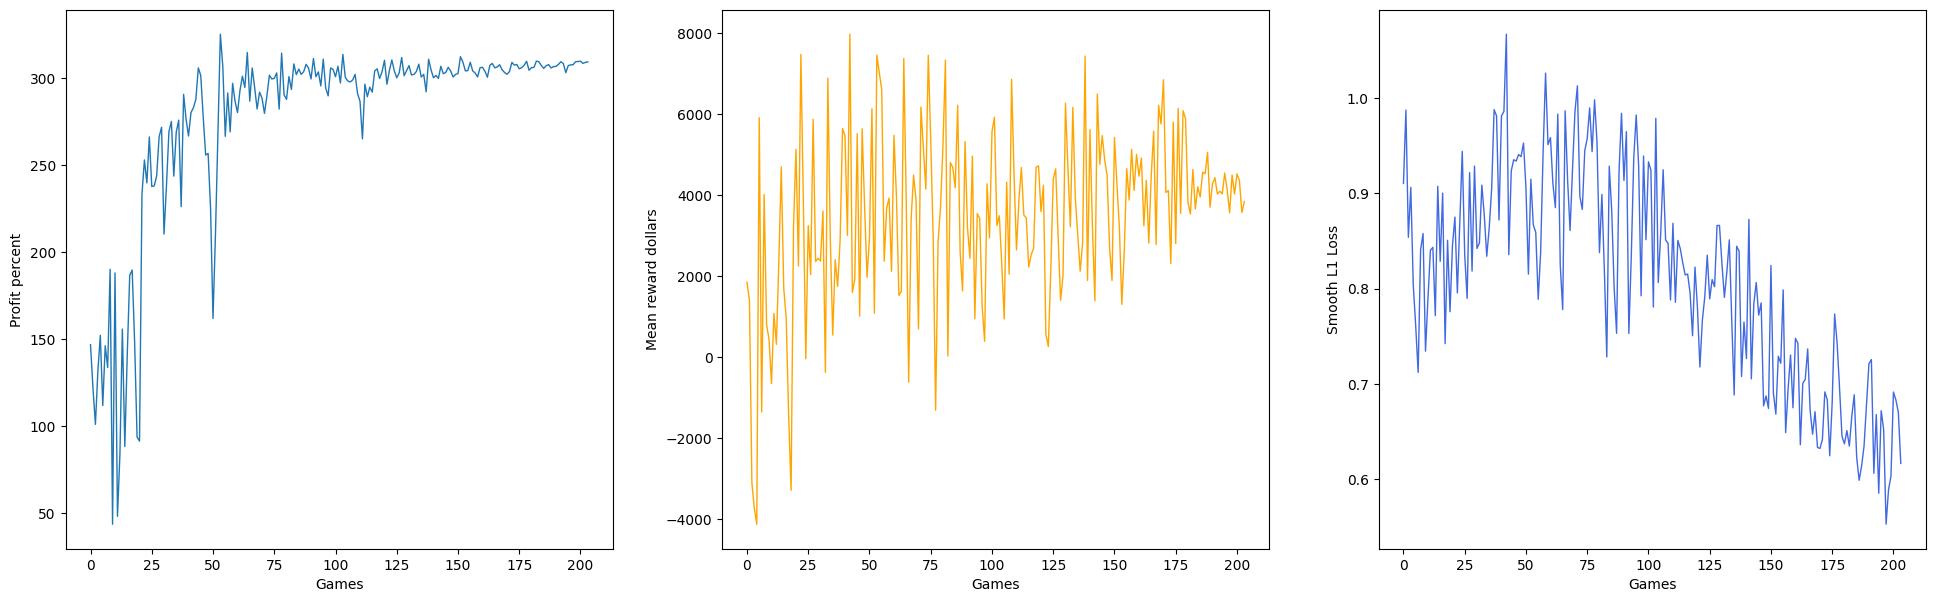

In [704]:
fig, ax=plt.subplots(1,3, figsize=(24,7))
ax[0].plot(np.array(plot_profit)*100,  linewidth=1) #profit as a percentage
ax[0].set(xlabel='Games', ylabel='Profit percent')

ax[1].plot(plot_reward, linewidth=1, color='orange')
ax[1].set(xlabel='Games', ylabel='Mean reward dollars')

ax[2].plot(plot_loss, linewidth=1, color='royalblue')
ax[2].set(xlabel='Games', ylabel='Smooth L1 Loss')

## **Visualize Actions**, **Positive: BUY, Negative: SELL**

<ipython-input-705-e173f20f7b44>:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game180')

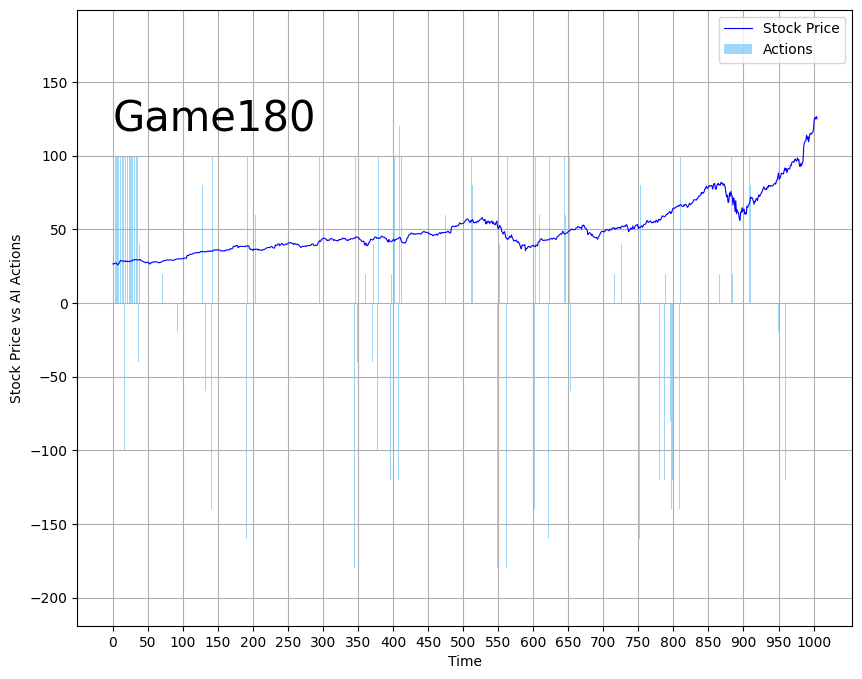

In [705]:
plt.figure(figsize=(10,8))
game_i=180 #input this to see actions in game i
game_length=stock_price_train.shape[0]-CONTEXT  #length of stock price
# np.pad(stock_price, (CONTEXT//2,CONTEXT//2),'constant', constant_values=(stock_price[0], stock_price[-1]))
#visualize actions
# plt.plot(np.array(actions[game_length*game_i:game_length*(game_i+1)])/50,linewidth=1, color='tomato', label='Actions')
plt.bar(x=np.arange(0,game_length), height=np.array(actions[game_length*game_i:game_length*(game_i+1)])/10, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_train, linewidth=0.8, color="blue", label='Stock Price')

#plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_train.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)

### **Test on unseen graph**

In [706]:
agent.n_games=10000
actions_test=[]
plot_profit_test=[]
plot_reward_test=[]
def test():
    rewards = []
    record = 0
    game = Game(w=CONTEXT, stock=stock_test, stock_price=stock_price_test, transformer_pred=transformer_pred_test)
    epoch=5000 #a very large number just to keep the game running
    for i in tqdm( range(1,epoch+1) ):
        
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions_test.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)

        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward_test.append(mean_reward)
            rewards=[]
            game.reset()
            agent.n_games += 1
            if profit > record:
                record = profit

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon)

            plot_profit.append(profit)



In [707]:
test()

 14%|█▍        | 711/5000 [00:01<00:08, 487.15it/s]

Game 10001 mean Reward 5744.71 Profit 43.09 Record: 43.09 eps 5


 28%|██▊       | 1389/5000 [00:02<00:06, 529.49it/s]

Game 10002 mean Reward 1714.44 Profit 42.56 Record: 43.09 eps 5


 40%|███▉      | 1977/5000 [00:04<00:07, 398.10it/s]

Game 10003 mean Reward 4293.46 Profit 43.12 Record: 43.12 eps 5


 52%|█████▏    | 2605/5000 [00:05<00:06, 366.35it/s]

Game 10004 mean Reward 4406.44 Profit 43.42 Record: 43.42 eps 5


 66%|██████▌   | 3288/5000 [00:07<00:03, 570.10it/s]

Game 10005 mean Reward 3091.03 Profit 44.1 Record: 44.1 eps 5


 79%|███████▉  | 3948/5000 [00:08<00:01, 589.27it/s]

Game 10006 mean Reward 3584.57 Profit 42.93 Record: 44.1 eps 5


 92%|█████████▏| 4587/5000 [00:09<00:00, 550.25it/s]

Game 10007 mean Reward 311.45 Profit 42.39 Record: 44.1 eps 5


100%|██████████| 5000/5000 [00:10<00:00, 488.04it/s]


<ipython-input-708-342b5356df6d>:14: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game1')

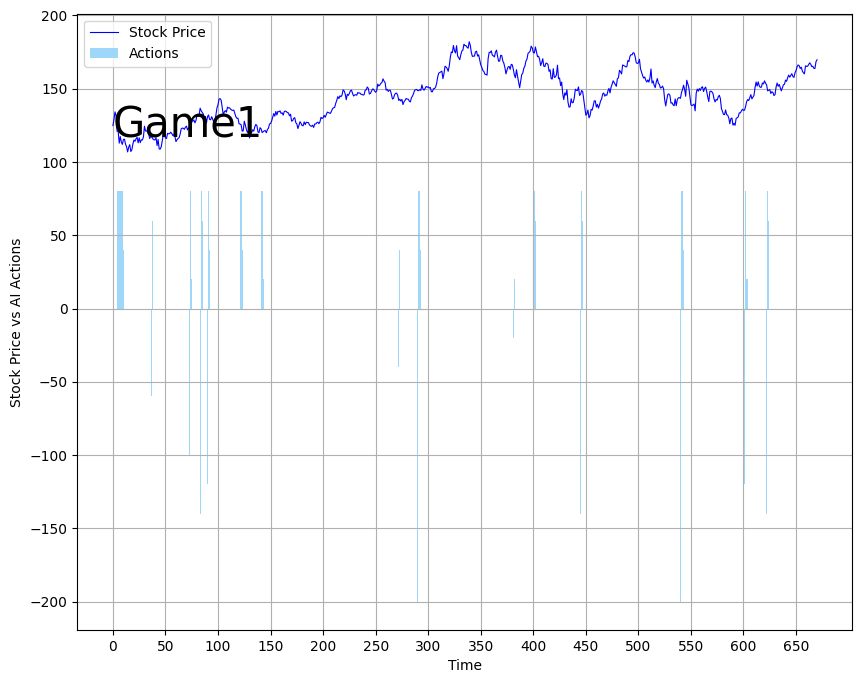

In [708]:
plt.figure(figsize=(10,8))
game_i=1 #input this to see actions in game i
game_length=stock_price_test.shape[0]-CONTEXT  #length of stock price
plt.bar(x=np.arange(0,game_length), height=np.array(actions_test[game_length*game_i:game_length*(game_i+1)])/10, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_test, linewidth=0.8, color="blue", label='Stock Price')

#plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_test.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)